Лабораторна робота №2 (Варіант 3)
1.	Сформувати тестову вибірку зображень з вихідного пакета;
2.	Для кожного каналу кольору кожного зображення з тестового пакета обчислити наступні характеристики:
a.	Математичне сподівання і дисперсію;
b.	Коефіцієнти асиметрії та ексцесу (нормалізований);
3.	Побудувати вектори параметрів зображень, що складаються з:
a.	Математичних очікувань значень яскравості для кожного каналу кольору;
b.	Математичних очікувань і дисперсії значень яскравості для кожного каналу кольору;
c.	Математичних очікувань, дисперсії і коефіцієнта асиметрії значень яскравості для кожного каналу кольору;
d.	Математичних очікувань, дисперсії, коефіцієнтів асиметрії та ексцесу значень яскравості для кожного каналу кольору;
4.	Побудувати гаусові моделі зображень з використанням розрахованих раніше параметрів.
5.	Провести декомпозицію кожного каналу кольору кожного зображення з застосуванням методу головних компонент (PCA):
a.	Варіюючи кількість компонент, провести реконструкцію окремих каналів кольору зображень (від компонент з найбільшою енергією поступово переходячи до компонентів з мінімальною енергією).
b.	Побудувати залежність помилки відновлення (середнє відхилення вихідного зображення відреконструйованого, MSE) від кількості використаних компонент.
6.	Провести моделювання окремих каналів кольору зображень з використанням марковських ланцюгів:
a.	Для кожного каналу кольору кожного зображення розрахувати стохастическую матрицю марковської ланцюга першого і другого порядків (обробка пікселів по горизонталі справа наліво і навпаки, а також по вертикалі зверху вниз і навпаки). У звіті привести явний вигляд однієї марковської ланцюга для одного з каналів кольору тестового зображення;
b.	Перевірити властивість регулярності, реккурентное і незворотності (irreducible) для отриманих марковских моделей для 5 ітерацій.


In [58]:
from os import listdir

from matplotlib import image as img
import matplotlib.pyplot as plt 

import scipy
import scipy.ndimage

import random
import numpy as np 
from PIL import Image
import networkx as nx
import pandas as pd
import quantecon as qe

In [75]:
# 1.generate a test sample of images from the source package

np.random.RandomState(3)
sample_size = 250
indexes = np.random.choice(range(25000), sample_size)
images = list()
for i in range(sample_size):
    filename = 'im' + str(indexes[i]) + '.jpg'
    img_data = img.imread('E:/Labs/mirflickr/' + filename)
    images.append(img_data)

print(f'{sample_size} images uploaded, processing begins...')

values = np.zeros((3, 256))
for image in images:
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            values[0][image[i][j][0]] += 1
            values[1][image[i][j][1]] += 1
            values[2][image[i][j][2]] += 1
            
print('all images processed')

250 images uploaded, processing begins...
all images processed


In [78]:
# 2.for each color channel of each image in the test package, calculate the following characteristics: 

colors = {
    'RED': 0,
    'GREEN': 1,
    'BLUE': 2
}

# a.expectation and variance

expectations = {
    'RED': 0,
    'GREEN': 0,
    'BLUE': 0  
}

variances = {
    'RED': 0,
    'GREEN': 0,
    'BLUE': 0  
}

for color in colors:
    print(color + ':')
    sum_values = sum(values[colors[str(color)]])
    expectation = 0
    for i in range(len(values[colors[str(color)]])):
        p = (values[colors[str(color)]][i] / sum_values)
        expectation += p * i
    variance = 0
    for i in range(len(values[colors[str(color)]])):
        p = (values[colors[str(color)]][i] / sum_values)
        variance += p * ((i - expectation) ** 2)
        
    expectations[str(color)] = expectation
    variances[str(color)] = variance
    print(f'expectation - {expectation}')
    print(f'variance - {variance}')

RED:
expectation - 118.0212951406293
variance - 6046.004677937074
GREEN:
expectation - 110.16358232767844
variance - 5723.162584113702
BLUE:
expectation - 100.94022637322685
variance - 6117.5026395624645


In [79]:
# b. сoefficients of asymmetry and excess


asymmetries = {
    'RED': 0,
    'GREEN': 0,
    'BLUE': 0  
}

excesses = {
    'RED': 0,
    'GREEN': 0,
    'BLUE': 0  
}

def finder(array, expectation, power):
    summa_values = sum(array)
    final = 0
    for i in range(len(array)):
        p = (array[i] / summa_values)
        final += p * ((i - expectation) ** power)
    return final


for color in colors:
    print(color + ':')
    asymmetry = finder(values[colors[color]], expectations[color], 3) / (variances[color] ** (3 / 2))
    excess = finder(values[colors[color]], expectations[color], 4) / (variances[color] ** 2) - 3
    
    asymmetries[str(color)] = asymmetry
    excesses[str(color)] = excess
    
    print(f'asymmetry - {asymmetry}')
    print(f'excess - {excess}')

RED:
asymmetry - 0.10142663138630191
excess - -1.2024401239735634
GREEN:
asymmetry - 0.21888462250400514
excess - -1.1213572009721986
BLUE:
asymmetry - 0.39093833763692565
excess - -1.0861327638833809


In [94]:
# 3.construct vectors of image parameters consisting of:

vector = np.array([np.array([expectations['RED'], variances['RED'], asymmetries['RED'], excesses['RED']]),
                   np.array([expectations['GREEN'], variances['GREEN'], asymmetries['GREEN'], excesses['GREEN']]),
                   np.array([expectations['BLUE'], variances['BLUE'], asymmetries['BLUE'], excesses['BLUE']])])

print("Vector:\n" + str(vector))
vector = np.copy(vector)
for im in images:
    im = np.reshape(im, (-1, 3))
    im = np.swapaxes(im, 0, 1)
    vector = np.concatenate((vector,im),axis=1)
    

Vector:
[[ 1.18021295e+02  6.04600468e+03  1.01426631e-01 -1.20244012e+00]
 [ 1.10163582e+02  5.72316258e+03  2.18884623e-01 -1.12135720e+00]
 [ 1.00940226e+02  6.11750264e+03  3.90938338e-01 -1.08613276e+00]]


In [93]:
# 4. build Gaussian models of images using previously calculated parameters.        
# a.expectations of brightness values

x1 = np.random.normal(expectations['GREEN'], variances['GREEN'], 1)
print("expectations of brightness values:\n" + str(x1))

expectations of brightness values:
[-2747.03159443]


In [81]:
# b.expectations and variance of brightness values

x2 = np.cov(vector)
print("expectations and variance of brightness values:\n" + str(x2[:2, :2]))

expectations and variance of brightness values:
[[6046.77719226 5220.911815  ]
 [5220.911815   5723.85514798]]


In [82]:
# c.expectations, variance and asymmetry of brightness values

print("expectations and variance of brightness values:\n" + str(x2[:3, :3]))

expectations and variance of brightness values:
[[6046.77719226 5220.911815   4645.47605222]
 [5220.911815   5723.85514798 5379.53147581]
 [4645.47605222 5379.53147581 6118.29823466]]


In [83]:
# d.expectations, variance, asymmetry and excess brightness values

print("expectations, variance, asymmetry and excess brightness values:\n" + str(x2[:4, :4]))

expectations, variance, asymmetry and excess brightness values:
[[6046.77719226 5220.911815   4645.47605222]
 [5220.911815   5723.85514798 5379.53147581]
 [4645.47605222 5379.53147581 6118.29823466]]


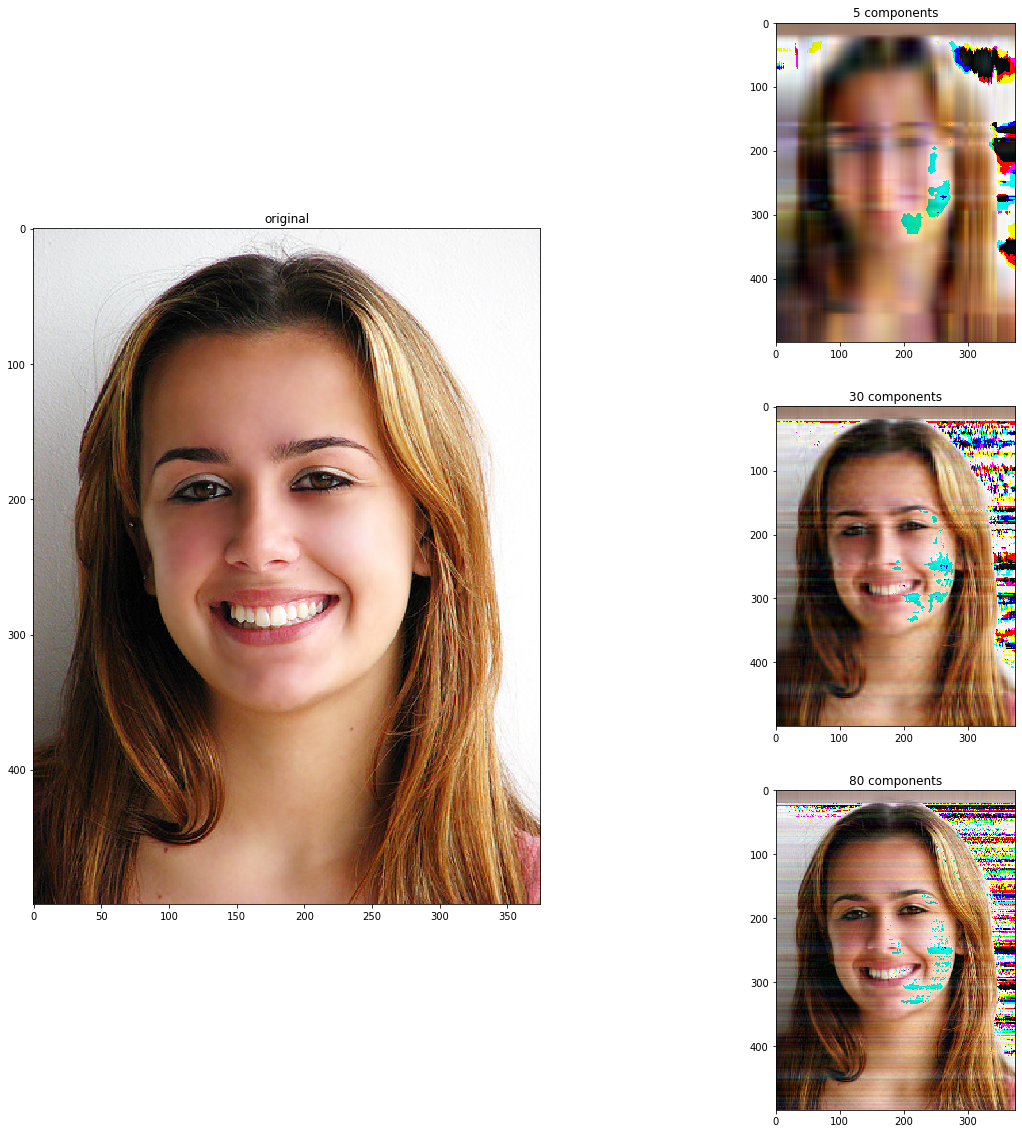

In [84]:
# 5. decompose each color channel of each image using the principal component method (PCA): 

# a. varying the number of components, to reconstruct individual color channels of images 
# (from the components with the highest energy, gradually moving to the components with the lowest energy)

test = images[3] # select the image according to the option
test_np = np.array(test)
test_r = test_np[:,:,0]
test_g = test_np[:,:,1]
test_b = test_np[:,:,2]

def PCA(img_2d, nmpc):
    cov_mat = img_2d - np.mean(img_2d)
    val, vec = np.linalg.eigh(np.cov(cov_mat))
    p = np.size(vec, axis =1)
    i = np.argsort(val)
    i = i[::-1]
    vec = vec[:, i]
    val = val[i]
    
    if (nmpc <p) or (nmpc >0):
       vec = vec[:, range(nmpc)]
    
    score = np.dot(vec.T, cov_mat)
    rcn = np.dot(vec, score) + np.mean(img_2d).T
    rcn_img_mat = np.uint8(np.absolute(rcn))
    return rcn_img_mat


number_of_comp = [5, 30, 80]
fig=plt.figure(figsize=(20,20))
fig.add_subplot(1, 2, 1)
plt.title('original')
plt.imshow(images[3])

k = 2
for number in number_of_comp:
    test_r_rcn, test_g_rcn, test_b_rcn = PCA(test_r, number), PCA(test_g, number), PCA(test_b, number)
    rcn_img = np.dstack((test_r_rcn, test_g_rcn, test_b_rcn))
    fig.add_subplot(3, 2, k)
    plt.title(f'{number} components')
    plt.imshow(rcn_img)
    k += 2


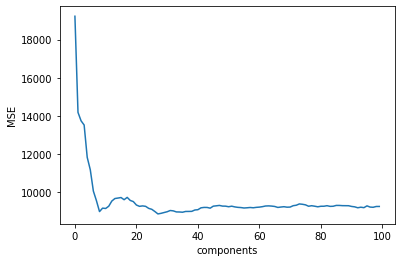

In [85]:
# b. construct the dependence of the recovery error (the average deviation of the original 
# image of the reconstructed, MSE) on the number of components used

def my_mse(first_img, second_img):
    err = np.sum((first_img.astype("float") - second_img.astype("float")) ** 2)
    err /= float(first_img.shape[0] * first_img.shape[1])
    
    return err

all_mse = list()
for i in range(100):
    test_r_recon, test_g_recon, test_b_recon = PCA(test_r, i), PCA(test_g, i), PCA(test_b, i)
    rcn_img = np.dstack((test_r_recon, test_g_recon, test_b_recon))
    all_mse.append(my_mse(test, rcn_img))
    
plt.plot(range(len(all_mse)),all_mse)
plt.xlabel("components")
plt.ylabel("MSE")
plt.show()

In [86]:
#6 markov chain:

matrix1 = np.zeros(shape=(256, 256))
array = test_r.flatten()
for i in range(len(array) - 1):
    matrix1[array[i]][array[i + 1]] += 1
matrix = matrix1[0] / sum(matrix1[0])
for i in range(1, 256):
    matrix = np.vstack((matrix, matrix1[i] / sum(matrix1[i])))
    
print("c-type matrix for RED first order:\n", matrix)
print("\nc-type matrix for RED second order:\n", np.linalg.matrix_power(matrix, 2))


c-type matrix for RED first order:
 [[0.02673797 0.01604278 0.02139037 ... 0.         0.         0.        ]
 [0.         0.01265823 0.02531646 ... 0.         0.         0.        ]
 [0.00772201 0.02316602 0.06949807 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.30825881 0.25039453 0.0865334 ]
 [0.         0.         0.         ... 0.18370987 0.43836702 0.21858898]
 [0.         0.         0.         ... 0.05897167 0.22749213 0.56117524]]

c-type matrix for RED second order:
 [[1.02521042e-02 1.07558077e-02 1.81771263e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.48075910e-02 1.78240758e-02 3.14417971e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.69735841e-02 2.13140361e-02 3.95747106e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.59023948e-06 1.07552428e-06 3.08829116e-06 ... 1.98097139e-01
  2.32337714e-01 1.43301834e-01]
 [2.69223191e-06 3.69044271e-07 4.67398051e-07 ... 1.68978381e-01
  2.97326558e-0

In [87]:

test_list = [test_r, test_g, test_b]
col = ['RED', 'GREEN', 'BLUE']

c = 0
for color in test_list:
    matrix1 = np.zeros(shape=(256, 256))
    #Fortran-type
    array = color.flatten('F')
    prev_color = array[0]
    for i in range(len(array) - 1):
        matrix1[array[i]][array[i + 1]] += 1
    matrix = matrix1[0] / sum(matrix1[0])
    for i in range(1, 256):
        matrix = np.vstack((matrix, matrix1[i] / sum(matrix1[i])))
    
    print(f'fortran-type matrix for {col[c]} first oder:\n', matrix)
    print(f'\nfortran-type matrix for {col[c]} second order:\n', np.linalg.matrix_power(matrix, 2))
    c +=1 


fortran-type matrix for RED first oder:
 [[0.18181818 0.06951872 0.06951872 ... 0.         0.         0.        ]
 [0.05063291 0.06329114 0.10759494 ... 0.         0.         0.        ]
 [0.03474903 0.04633205 0.1003861  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.38847975 0.24381904 0.06102052]
 [0.         0.         0.         ... 0.18588981 0.51823226 0.2039239 ]
 [0.         0.         0.         ... 0.04407135 0.2207765  0.65897167]]

fortran-type matrix for RED second order:
 [[0.04874816 0.0325217  0.04968645 ... 0.         0.         0.        ]
 [0.02861077 0.0289772  0.05164356 ... 0.         0.         0.        ]
 [0.02732353 0.03126042 0.05560623 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24875751 0.25106908 0.1231492 ]
 [0.         0.         0.         ... 0.1901084  0.36313839 0.25390456]
 [0.         0.         0.         ... 0.09381796 0.27298338 0.48348566]]
fortran-type matrix for GRE

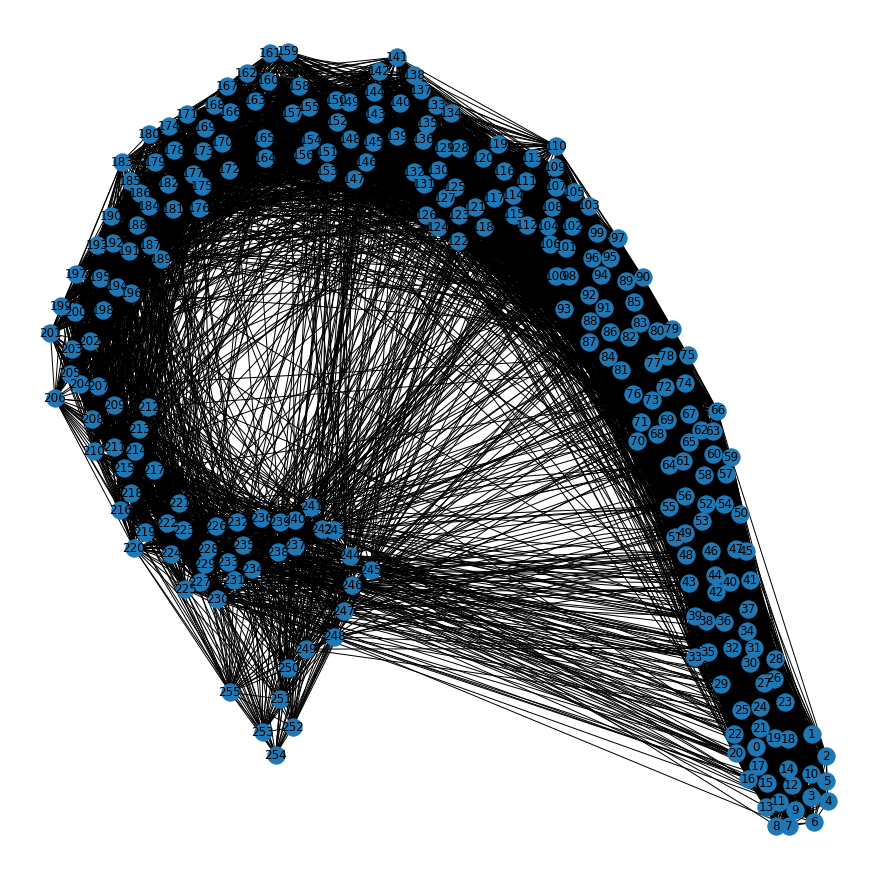

In [88]:
data = np.triu(matrix) + np.triu(matrix).T
index = [str(i) for i in range(data.shape[0])]
dataframe = pd.DataFrame(data, index=index, columns=index)
plt.figure(1,figsize=(12,12))  
g = nx.from_pandas_adjacency(dataframe)

nx.draw(g, with_labels=True)
plt.show()

In [89]:
test = pd.DataFrame(matrix)
test

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.081949,0.031008,0.028793,0.040975,0.039867,0.037652,0.037652,0.040975,0.029900,0.045404,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.038043,0.032609,0.051630,0.073370,0.081522,0.062500,0.048913,0.038043,0.024457,0.027174,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.039604,0.019802,0.061056,0.051155,0.075908,0.074257,0.062706,0.059406,0.036304,0.052805,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.039801,0.032338,0.049751,0.095771,0.104478,0.085821,0.054726,0.052239,0.037313,0.034826,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.035951,0.020814,0.052980,0.078524,0.098392,0.085147,0.054872,0.064333,0.042573,0.042573,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010006,0.028840,0.047087,0.091819,0.156563,0.231901,0.218952,0.102413,0.042378,0.020600
252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009761,0.010249,0.019522,0.040996,0.069302,0.172767,0.288433,0.244998,0.074671,0.037091
253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004428,0.003321,0.007380,0.015498,0.028782,0.064576,0.171218,0.396310,0.236162,0.056458
254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000794,0.002646,0.002116,0.004233,0.008995,0.020899,0.038624,0.164021,0.541270,0.208730


In [90]:
def regularity_check(matrix):
    counter = 0
    for a in range(1,6):
        matrix = np.linalg.matrix_power(matrix,a)

        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if matrix[i,j] < 0:
                    counter += 1 
        print('iteration: ' , a, 'negative elements: ' ,counter)
        
regularity_check(matrix)
print('Для 5 ітерації ,виконується умова регулярності.Модель регулярна ')

P = matrix
mc = qe.MarkovChain(P, [str(i) for i in range(0,256)])
print('Модель незворотня -  ', mc.is_irreducible)
print('Рекурентную називають модель M  яка з ймовірністю в P = 1 при покиданні стану вернеться в цей стан за час t < inf,у майбутньму')
print("Кількість рекурентних станів " ,np.shape(mc.recurrent_classes)[1])
if np.shape(mc.recurrent_classes_indices)[1] == 256:
    print('Усі стани моделі рекурентні ,модель рекурентна ')
else :
    print('Модель не рекурентна' )

iteration:  1 negative elements:  0
iteration:  2 negative elements:  0
iteration:  3 negative elements:  0
iteration:  4 negative elements:  0
iteration:  5 negative elements:  0
Для 5 ітерації ,виконується умова регулярності.Модель регулярна 
Модель незворотня -   True
Рекурентную називають модель M  яка з ймовірністю в P = 1 при покиданні стану вернеться в цей стан за час t < inf,у майбутньму
Кількість рекурентних станів  256
Усі стани моделі рекурентні ,модель рекурентна 
